In [21]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
from IPython.display import Audio

import torchaudio
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import Wav2Vec2Processor, Wav2Vec2Model, Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification

import warnings
warnings.filterwarnings("ignore")


In [22]:
paths = []
labels = []z
for dirname, _, filenames in os.walk('/mnt/c/Users/leoni/Desktop/CodeAlpha/CodeAlpha_Emotion_Speech_Recognation/TESS Toronto emotional speech set data'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print("Datatset is loaded")

Datatset is loaded


In [23]:
len(paths)

2800

In [24]:
## Create a datafile
df = pd.DataFrame()
df['audio_paths'] = paths
df['labels'] = labels
df.head()


,audio_paths,labels
0,/mnt/c/Users/leoni/Desktop/CodeAlpha/CodeAlpha...,angry
1,/mnt/c/Users/leoni/Desktop/CodeAlpha/CodeAlpha...,angry
2,/mnt/c/Users/leoni/Desktop/CodeAlpha/CodeAlpha...,angry
3,/mnt/c/Users/leoni/Desktop/CodeAlpha/CodeAlpha...,angry
4,/mnt/c/Users/leoni/Desktop/CodeAlpha/CodeAlpha...,angry


In [25]:
df['labels'].value_counts()

labels
angry      400
disgust    400
fear       400
happy      400
neutral    400
ps         400
sad        400
Name: count, dtype: int64

# Exploratory Data Analysis

<Axes: xlabel='labels', ylabel='count'>

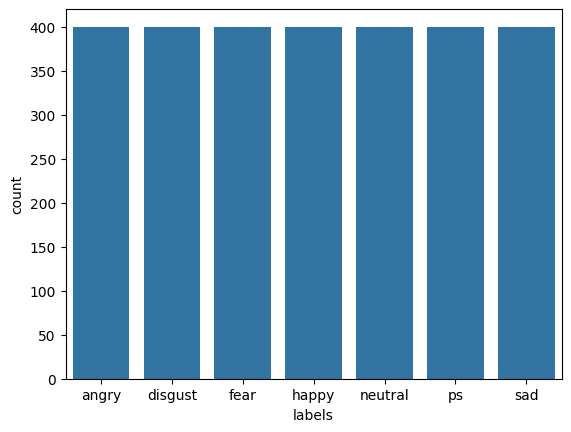

In [26]:
sns.countplot(data=df, x='labels')

In [27]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

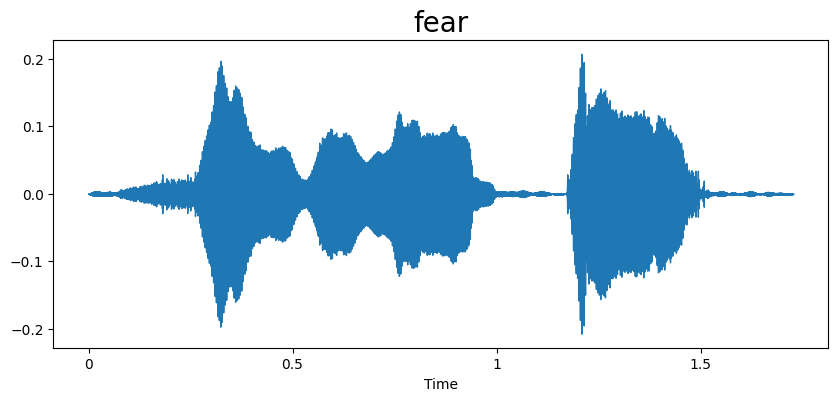

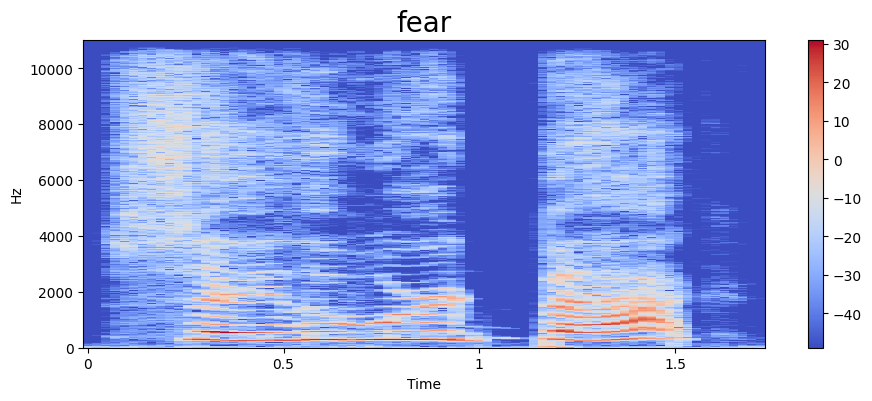

In [28]:
emotion = 'fear'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

# Create Custom Dataset Class

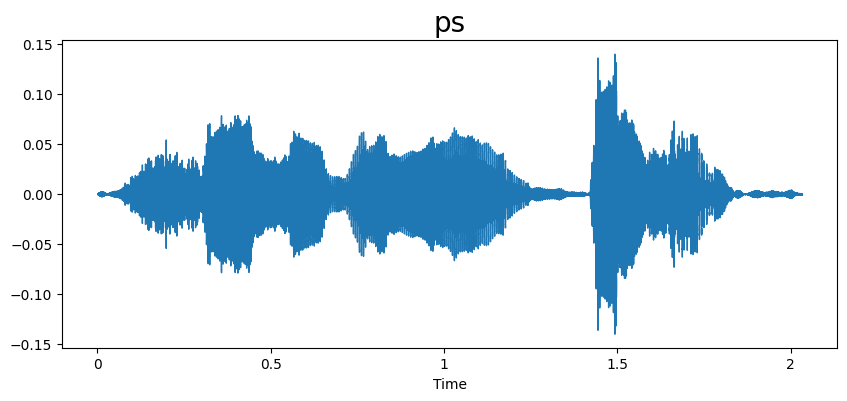

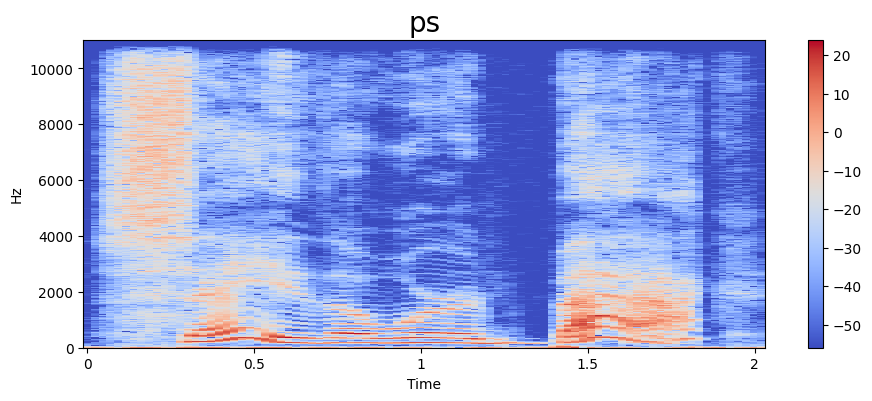

In [29]:
emotion = 'ps'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [30]:
# Convert labes to numbers
label_map = {label: num for num, label in enumerate(np.unique(df['labels']))}
inverse_label_map = {v: k for k, v in label_map.items()}
df["labels"] = df["labels"].map(label_map)
df.head()

,audio_paths,labels
0,/mnt/c/Users/leoni/Desktop/CodeAlpha/CodeAlpha...,0
1,/mnt/c/Users/leoni/Desktop/CodeAlpha/CodeAlpha...,0
2,/mnt/c/Users/leoni/Desktop/CodeAlpha/CodeAlpha...,0
3,/mnt/c/Users/leoni/Desktop/CodeAlpha/CodeAlpha...,0
4,/mnt/c/Users/leoni/Desktop/CodeAlpha/CodeAlpha...,0


In [31]:
class SpeechEmotionDataset(Dataset):
    def __init__(self, df, processor, max_length=32000):
        self.df = df
        self.processor = processor
        self.max_length = max_length
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['audio_paths']
        label = self.df.iloc[idx]['labels']
        
        #load audio
        speech, sr = librosa.load(audio_path, sr=16000)
        
        # pad or truncate the speech to the requiered length
        if len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech, (0, self.max_length - len(speech)), mode='constant')
        
        # apply the processing
        inputs = self.processor(speech, sampling_rate=16000, return_tensors='pt', padding=True, truncate=True, max_length=self.max_length)
        
        input_values = inputs.input_values.squeeze()
        return {'input_values': input_values, 'labels': torch.tensor(label, dtype=torch.long)}

In [32]:
# split the data for train and test
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [33]:
# initialize the processor and model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=7)


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
# load the dataset
train_dataset = SpeechEmotionDataset(train_df, processor)
test_dataset = SpeechEmotionDataset(test_df, processor)

In [35]:
# create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [36]:
train_dataset[0]['input_values'].size()

torch.Size([32000])

## Set Training Arguments

In [37]:
training_args = TrainingArguments(
    output_dir = './results',
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate = 2e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 3,
    weight_decay = 0.01,
    report_to = [],
)

In [38]:
# create functions for computing metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def computer_metrics(pred):
    labels = pred.label_ids # true labels
    preds = np.argmax(pred.predictions, axis=1) # predicted labels
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [39]:
# initialize the trainer
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    compute_metrics = computer_metrics
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.479441,1.000000,1.000000,1.000000,1.000000
2,No log,0.178578,1.000000,1.000000,1.000000,1.000000
3,No log,0.137690,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=420, training_loss=0.5851869855608259, metrics={'train_runtime': 272.6178, 'train_samples_per_second': 24.65, 'train_steps_per_second': 1.541, 'total_flos': 1.2201848064e+17, 'train_loss': 0.5851869855608259, 'epoch': 3.0})

In [40]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.13768987357616425, 'eval_accuracy': 1.0, 'eval_f1': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_runtime': 8.7265, 'eval_samples_per_second': 64.172, 'eval_steps_per_second': 4.011, 'epoch': 3.0}


# Test Predictions

In [41]:
import random
idx = random.randrange(0, len(test_dataset))
print("Original label: ", inverse_label_map[int(test_dataset[idx]['labels'])])
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

with torch.no_grad():
    outputs = model(input_values)
logits = outputs.logits

predicted_class = logits.argmax(dim=-1).item()
print("Predicted label: ", inverse_label_map[predicted_class])

Original label:  happy
Predicted label:  happy


In [42]:
import random
idx = random.randrange(0, len(test_dataset))
print("Original label: ", inverse_label_map[int(test_dataset[idx]['labels'])])
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

with torch.no_grad():
    outputs = model(input_values)
logits = outputs.logits

predicted_class = logits.argmax(dim=-1).item()
print("Predicted label: ", inverse_label_map[predicted_class])

Original label:  fear
Predicted label:  fear
